In [36]:
import pandas as pd
from IPython.display import SVG
import numpy as np
import os

from sklearn import model_selection
from sklearn import metrics

from keras import layers
from keras import models
from keras.utils import plot_model
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing.text import Tokenizer
from keras import backend as K

In [2]:
df = pd.read_csv('train.csv').sample(5000)


In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
155340,155340,243377,243378,What should I know about human behavior if I w...,What should I know about human behaviour if I ...,1
402882,402882,12957,46022,Has Ancient Mesopotamia been scientifically te...,Have Ancient Akkadians been scientifically tes...,1
263329,263329,293113,379856,What is the difference between group discussio...,What is the difference between a group discuss...,0
81819,81819,84569,138857,How many valence electrons does oxygen have?,What am I if I call myself an electron of vale...,0
85491,85491,144334,144335,Is Telugu older than Tamil?,Which language is older telugu or tamil?,1


In [25]:
df['question1'] = df['question1'].fillna('').str.lower().str.replace('[^A-Za-z0-9?!]+', ' ')
df['question2'] = df['question2'].fillna('').str.lower().str.replace('[^A-Za-z0-9?!]+', ' ')

In [5]:
df['question1_len'] = df['question1'].fillna('').apply(lambda r: len(r.split(' ')))
df['question2_len'] = df['question2'].fillna('').apply(lambda r: len(r.split(' ')))

In [6]:
df_train, df_val = model_selection.train_test_split(df)

In [7]:
x1_train = pad_sequences(df_train['question1'].apply(lambda r: one_hot(r, 500000)), 100)
x2_train = pad_sequences(df_train['question2'].apply(lambda r: one_hot(r, 500000)), 100)

x1_val = pad_sequences(df_val['question1'].apply(lambda r: one_hot(r, 500000)), 100)
x2_val = pad_sequences(df_val['question2'].apply(lambda r: one_hot(r, 500000)), 100)

In [33]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([df_train['question1'], df_train['question2']]))
sequences1 = tokenizer.texts_to_sequences(df_train['question1'])
sequences2 = tokenizer.texts_to_sequences(df_train['question2'])

word_index = tokenizer.word_index
print('Found {0} unique tokens.'.format(len(word_index)))

Found 8837 unique tokens.


In [ ]:
embeddings_index = {}

f = open(os.path.join('/home/eric/data', 'glove.42B.300d.txt'))

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    if word in word_index:
        embeddings_index[word] = coefs

f.close()

print('Found {0} word vectors.'.format(len(embeddings_index)))

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

## Siamese MaLSTM

Inspired from [How to predict Quora Question Pairs using Siamese Manhattan LSTM](https://medium.com/mlreview/implementing-malstm-on-kaggles-quora-question-pairs-competition-8b31b0b16a07)

/home/eric/code/venvs/data3/lib/python3.5/site-packages/ipykernel_launcher.py:19: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/eric/code/venvs/data3/lib/python3.5/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


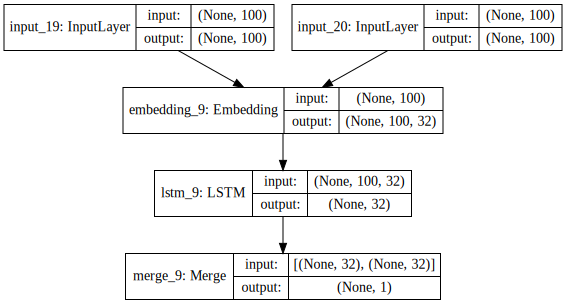

In [19]:
def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

shared_embedding = Embedding(input_dim=len(word_index) + 1,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=100,
                            trainable=False)

shared_lstm = layers.LSTM(32)

x1a = layers.Input(shape=(100,), dtype='int32')
h1a = shared_embedding(x1a)
h1a = shared_lstm(h1a)

x1b = layers.Input(shape=(100,), dtype='int32')
h1b = shared_embedding(x1b)
h1b = shared_lstm(h1b)

malstm_distance = layers.merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),
                               output_shape=lambda x: (x[0][0], 1),
                               inputs=[h1a, h1b])

model = models.Model(inputs=[x1a, x1b],
                     outputs=[malstm_distance])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [9]:
model.fit(x=[x1_train, x2_train],
          y=df_train['is_duplicate'].values,
          validation_data=([x1_val, x2_val], df_val['is_duplicate'].values),
          epochs=3)

Train on 3750 samples, validate on 1250 samples
Epoch 1/3
3750/3750 [==============================] - 68s 18ms/step - loss: 0.2763 - acc: 0.5605 - val_loss: 0.2401 - val_acc: 0.5984
Epoch 2/3
3750/3750 [==============================] - 64s 17ms/step - loss: 0.1830 - acc: 0.7283 - val_loss: 0.2213 - val_acc: 0.6344
Epoch 3/3
3750/3750 [==============================] - 82s 22ms/step - loss: 0.1230 - acc: 0.8488 - val_loss: 0.2085 - val_acc: 0.6648
